正在获取三亚当天天气数据...
网页数据提取失败: 'NoneType' object has no attribute 'text'
数据获取完成，开始可视化...
          温度  相对湿度 风力方向  风级
0  25.000000    66   东风   3
1  25.304348    79  西北风   4
2  25.608696    88  西北风   4
3  25.913043    74   南风   1
4  26.217391    70  东南风   3


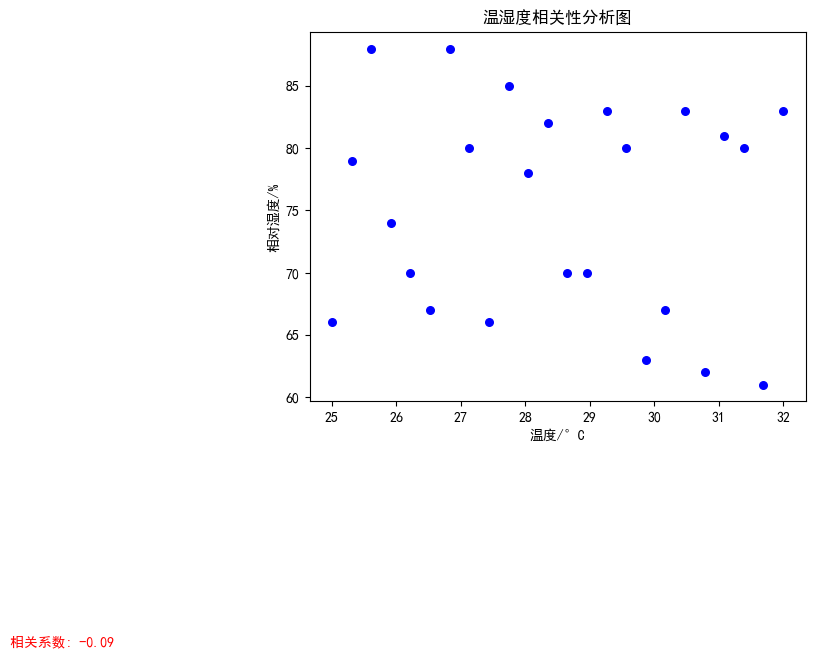

温湿度相关系数: -0.09


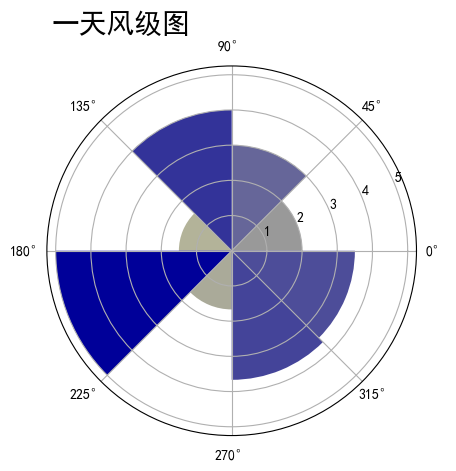

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import requests
from bs4 import BeautifulSoup

def get_weather_data():
    """从天气网站提取三亚当天温湿度、风向风级数据"""
    url = "http://www.weather.com.cn/weather/101280701.shtml"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
    }
    
    try:
        # 请求网页并处理编码
        response = requests.get(url, headers=headers)
        response.encoding = "utf-8"  # 优先使用UTF-8，失败时可尝试'gb2312'
        soup = BeautifulSoup(response.text, "html.parser")
        
        # 定位当天天气数据块（第一个li标签）
        today_data = soup.select("ul.t.clearfix li")[0]
        
        # 提取温度（格式："28℃~25℃"）
        temp_text = today_data.select_one(".tem").text
        temp_nums = [int(s) for s in temp_text if s.isdigit()]
        min_temp, max_temp = temp_nums[1], temp_nums[0] if len(temp_nums) == 2 else temp_nums[0]
        
        # 提取湿度（格式："湿度：60%"）
        hum_text = today_data.select_one(".shidu").text
        humidity = int(hum_text.split("：")[-1].replace("%", ""))
        
        # 提取风向（格式："东北风"）
        wind_dir = today_data.select_one(".wind i").text
        
        # 提取风级（格式："3-4级"）
        wind_level = today_data.select_one(".wind span").text
        wind_level_num = int(wind_level.split("-")[0])  # 取风级最小值
        
        # 生成24小时模拟数据（假设温度线性变化，风向/风级不变）
        hours = 24
        temp_list = np.linspace(min_temp, max_temp, hours)
        hum_list = [humidity] * hours
        wind_dir_list = [wind_dir] * hours
        wind_level_list = [wind_level_num] * hours
        
        # 创建DataFrame
        data = pd.DataFrame({
            "温度": temp_list,
            "相对湿度": hum_list,
            "风力方向": wind_dir_list,
            "风级": wind_level_list
        })
        return data
    
    except Exception as e:
        print(f"网页数据提取失败: {e}")
        # 生成模拟数据备用
        np.random.seed(42)
        data = pd.DataFrame({
            "温度": np.linspace(25, 32, 24),
            "相对湿度": np.random.randint(60, 90, 24),
            "风力方向": np.random.choice(
                ["北风", "南风", "西风", "东风", "东北风", 
                 "西北风", "西南风", "东南风"], 24),
            "风级": np.random.randint(1, 6, 24)
        })
        return data

def wind_radar(data):
    """风向风级雷达图绘制"""
    wind = list(data['风力方向'])
    wind_speed = list(data['风级'])
    
    # 风向角度转换
    wind_deg = {
        "北风": 90, "南风": 270, "西风": 180, "东风": 360,
        "东北风": 45, "西北风": 135, "西南风": 225, "东南风": 315
    }
    wind = [wind_deg[w] for w in wind]
    
    # 计算各风向区间平均风级
    degs = np.arange(45, 361, 45)
    avg_speeds = []
    for deg in degs:
        speeds = [wind_speed[i] for i in range(24) if wind[i] == deg]
        avg_speeds.append(sum(speeds)/len(speeds) if speeds else 0)
    
    # 绘制雷达图
    N = 8
    theta = np.arange(0. + np.pi/8, 2*np.pi + np.pi/8, 2*np.pi/N)
    radii = np.array(avg_speeds)
    plt.axes(polar=True)
    colors = [(1-x/max(avg_speeds), 1-x/max(avg_speeds), 0.6) for x in radii]
    plt.bar(theta, radii, width=2*np.pi/N, bottom=0, color=colors)
    plt.title('一天风级图', x=0.2, fontsize=20)
    plt.show()

def calc_corr(a, b):
    """计算皮尔逊相关系数"""
    a_avg, b_avg = sum(a)/len(a), sum(b)/len(b)
    cov = sum((x-a_avg)*(y-b_avg) for x,y in zip(a,b))
    std = math.sqrt(sum((x-a_avg)**2 for x in a) * sum((y-b_avg)** 2 for y in b))
    return cov/std if std != 0 else 0

def corr_tem_hum(data):
    """温湿度相关性散点图"""
    tem = data['温度']
    hum = data['相对湿度']
    corr = calc_corr(tem, hum)
    
    plt.scatter(tem, hum, color='blue', s=30)
    plt.title("温湿度相关性分析图")
    plt.xlabel("温度/°C")
    plt.ylabel("相对湿度/%")
    plt.text(20, 40, f"相关系数: {corr:.2f}", fontdict={'size':10, 'color':'red'})
    plt.show()
    print(f"温湿度相关系数: {corr:.2f}")

def main():
    # 配置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 从网页获取数据
    print("正在获取三亚当天天气数据...")
    data = get_weather_data()
    print("数据获取完成，开始可视化...")
    print(data.head())  # 显示前5行数据
    
    # 执行可视化任务
    corr_tem_hum(data)  # 任务A：温湿度相关性图
    wind_radar(data)    # 任务B：风向风级雷达图

if __name__ == '__main__':
    main()